In [1]:
#necessary package import
#Numpy
import numpy as np
from numpy.linalg import multi_dot
from math import factorial, tanh
#Matplotlib
import matplotlib.pyplot as plt
#Scipy
from scipy.linalg import block_diag
#Thewalrus
from thewalrus import perm
#Strawberryfields
import strawberryfields as sf
from strawberryfields.ops import *
#import mplhep as hep
#Qutip
from qutip import *

In [2]:
#Setting Variables
#Rotation gates
"""
R1 = 1
R2 = np.pi/4
R3 = 1
R4 = np.pi/4
"""
R1 = 0.5719
R2 = -1.9782
R3 = 2.0603
R4 = 0.0644
"""
#Beamsplitters
BT1 = np.pi/4;  BP1 = np.pi/2
BT2 = np.pi/4;  BP2 = np.pi/2
BT3 = np.pi/4;  BP3 = np.pi/2
BT4 = np.pi/4;  BP4 = np.pi/2
BT5 = np.pi/4;  BP5 = np.pi/2
BT6 = np.pi/4;  BP6 = np.pi/2
BT7 = np.pi/4;  BP7 = np.pi/2
BT8 = np.pi/4;  BP8 = np.pi/2

"""
BT1 = 0.7804;  BP1 = 0.8578
BT2 = 0.06406; BP2 = 0.5165
BT3 = 0.473;   BP3 = 0.1176
BT4 = 0.563;   BP4 = 0.1517
BT5 = 0.1323;  BP5 = 0.9946
BT6 = 0.311;   BP6 = 0.3231
BT7 = 0.4348;  BP7 = 0.0798
BT8 = 0.4368;  BP8 = 0.6157

In [39]:
# Calculating the probability for each state in measure_states
measure_states = [[q1, q2, q3, q4] for q1 in range(5) for q2 in range(5) for q3 in range(5) for q4 in range(5) if q1 + q2 + q3 + q4 == 4]

In [40]:
#Rotation gate calculation
Uphase = np.diag([np.exp(R1*1j),np.exp(R2*1j),np.exp(R3*1j),np.exp(R4*1j)])

In [41]:
#Beamsplitter calculation
#Put variables
BSargs = [(BT1, BP1),(BT2, BP2),
          (BT3, BP3),
          (BT4, BP4),(BT5, BP5),
          (BT6, BP6),
          (BT7, BP7),(BT8, BP8)]

t_r_amplitudes = [(np.cos(q), np.exp(p*1j)*np.sin(q)) for q,p in BSargs]

BSunitaries = [np.array([[t, -np.conj(r)], [r, t]]) for t,r in t_r_amplitudes]

UBS1 = block_diag(*BSunitaries[0:2])
UBS2 = block_diag([[1]], BSunitaries[2], [[1]])
UBS3 = block_diag(*BSunitaries[3:5])
UBS4 = block_diag([[1]], BSunitaries[5], [[1]])
UBS5 = block_diag(*BSunitaries[6:8])

In [42]:
U = multi_dot([UBS5, UBS4, UBS3, UBS2, UBS1, Uphase])
print(np.round(U,4))

[[ 0.2195-0.2565j  0.6111+0.5242j -0.1027+0.4745j -0.0273+0.0373j]
 [ 0.4513+0.6026j  0.457 +0.0123j  0.1316-0.4504j  0.0353-0.0532j]
 [ 0.0387+0.4927j -0.0192-0.3218j -0.2408+0.5244j -0.4584+0.3296j]
 [-0.1566+0.2246j  0.11  -0.1638j -0.4212+0.1836j  0.8188+0.068j ]]


In [43]:
#Theory calculation
input = [1, 1, 1, 1]

def probs_theory(output):
    # The two lines below are the extracted row and column indices.
    list_rows = sum([[i] * output[i] for i in range(len(output))],[])
    list_columns = sum([[i] * input[i] for i in range(len(input))],[])
    U_L = U[:,list_columns][list_rows,:]
    perm_squared = np.abs(perm(U_L, method="ryser"))**2
    denominator = np.prod([factorial(inp) for inp in input]) * np.prod([factorial(out) for out in output])
    return perm_squared / denominator

In [44]:
#initialize a 4 mode program
boson_sampling = sf.Program(4)

with boson_sampling.context as q:
    #Prepare the input fock states
    Fock(1)  |  q[0]
    Fock(1)  |  q[1]
    Fock(1)  |  q[2]
    Fock(1)  |  q[3] 

    #rotation gates
    Rgate(R1)  | q[0]
    Rgate(R2)  | q[1]
    Rgate(R3)  | q[2]
    Rgate(R4)  | q[3]

    #beamsplitter array
    BSgate(BT1, BP1)  | (q[0], q[1])
    BSgate(BT2, BP2)  | (q[2], q[3])
    BSgate(BT3, BP3)  | (q[1], q[2])
    BSgate(BT4, BP4)  | (q[0], q[1])
    BSgate(BT5, BP5)  | (q[2], q[3])
    BSgate(BT6, BP6)  | (q[1], q[2])
    BSgate(BT7, BP7)  | (q[0], q[1])
    BSgate(BT8, BP8)  | (q[2], q[3])

In [45]:
eng = sf.Engine(backend = "fock", backend_options = {"cutoff_dim" : 5})
results = eng.run(boson_sampling)
probs = results.state.all_fock_probs()

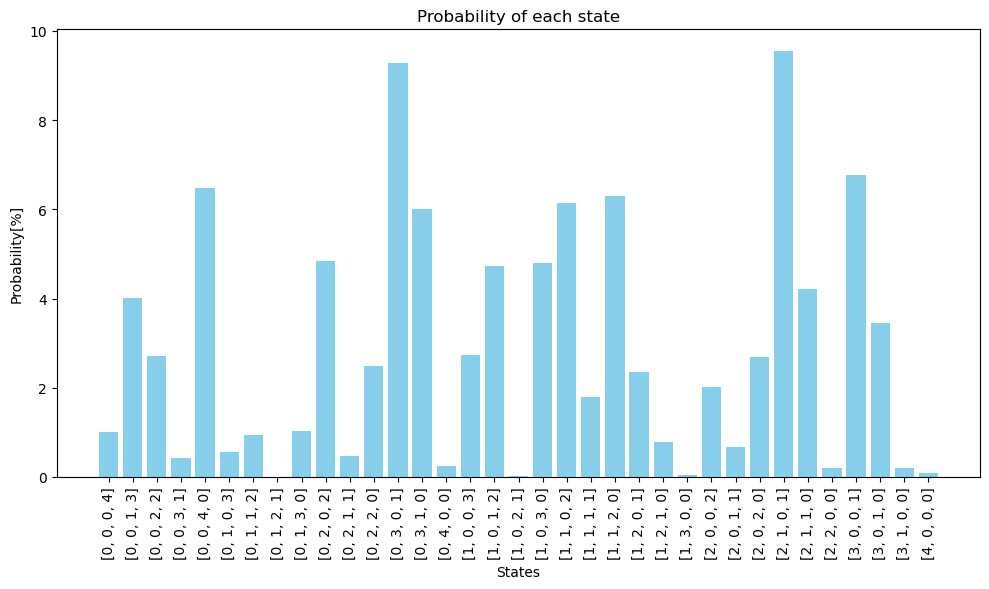

In [46]:
#Simulator probaibility
state_probs = [probs[tuple(state)]*100 for state in measure_states]

# Creating labels for the states
state_labels = [str(state) for state in measure_states]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(state_labels, state_probs, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("Probability[%]")
#plt.yscale('log')
plt.title("Probability of each state")
plt.tight_layout()

#이미지를 경로에 저장. 확장자는 .pdf, .png, .jpeg등 가능
#plt.savefig('/Users/jaewonlee/Lab/PQC/BS_Q_4(log).png', transparent = True)

# Showing the plot
plt.show()

In [30]:
#Comparing Theory and Simulation
# Initialize the total probability
total_probability_T = 0  
total_probability_S = 0

# measure_states의 각 상태에 대해 확률을 출력
for i, state in enumerate(measure_states):
    # 각 상태의 확률을 출력
    # *state는 state 리스트의 요소들을 개별 인자로 전달합니다.
    print(f"Probability of state(Theory)     {state}: {probs_theory(state)*100}%")
    print(f"Probability of state(Simulation) {state}: {probs[tuple(state)]*100}%")
    total_probability_T += probs_theory(state)
    total_probability_S += probs[tuple(state)]
    
# Print the total probability
print(f"Total probability(Theory):     {total_probability_T*100}%")
print(f"Total probability(Simulation): {total_probability_S*100}%")

Probability of state(Theory)     [0, 0, 0, 4]: 0.9976245740353498%
Probability of state(Simulation) [0, 0, 0, 4]: 0.9976245740353518%
Probability of state(Theory)     [0, 0, 1, 3]: 4.003119536853783%
Probability of state(Simulation) [0, 0, 1, 3]: 4.00311953685378%
Probability of state(Theory)     [0, 0, 2, 2]: 2.716416141240894%
Probability of state(Simulation) [0, 0, 2, 2]: 2.7164161412408885%
Probability of state(Theory)     [0, 0, 3, 1]: 0.414559085628145%
Probability of state(Simulation) [0, 0, 3, 1]: 0.41455908562814936%
Probability of state(Theory)     [0, 0, 4, 0]: 6.469120990886585%
Probability of state(Simulation) [0, 0, 4, 0]: 6.469120990886604%
Probability of state(Theory)     [0, 1, 0, 3]: 0.5511529064587104%
Probability of state(Simulation) [0, 1, 0, 3]: 0.5511529064587135%
Probability of state(Theory)     [0, 1, 1, 2]: 0.9347207459242995%
Probability of state(Simulation) [0, 1, 1, 2]: 0.934720745924297%
Probability of state(Theory)     [0, 1, 2, 1]: 0.0021064451472127665%

In [31]:
for i, state in enumerate(measure_states):
    T = probs_theory(state)
    S = probs[tuple(state)]
    E = 100*np.abs(T-S)/T
    Esum =+ E
    print(f"Error of state {state}: {E}%")
print(f"Average of Error: {Esum/len(measure_states)}%")

Error of state [0, 0, 0, 4]: 2.0866247938860485e-13%
Error of state [0, 0, 1, 3]: 6.933486587173754e-14%
Error of state [0, 0, 2, 2]: 1.9158222294884058e-13%
Error of state [0, 0, 3, 1]: 1.0670481041413552e-12%
Error of state [0, 0, 4, 0]: 2.788806110687115e-13%
Error of state [0, 1, 0, 3]: 5.665401053259573e-13%
Error of state [0, 1, 1, 2]: 2.783810272010317e-13%
Error of state [0, 1, 2, 1]: 1.045498699918785e-12%
Error of state [0, 1, 3, 0]: 0.0%
Error of state [0, 2, 0, 2]: 1.5755702760653036e-13%
Error of state [0, 2, 1, 1]: 7.442185214055765e-14%
Error of state [0, 2, 2, 0]: 8.405569391520325e-14%
Error of state [0, 3, 0, 1]: 5.987093828328573e-14%
Error of state [0, 3, 1, 0]: 1.4998518105641898e-13%
Error of state [0, 4, 0, 0]: 4.4158031590770907e-13%
Error of state [1, 0, 0, 3]: 2.5299866676327555e-14%
Error of state [1, 0, 1, 2]: 1.3214189115389482e-13%
Error of state [1, 0, 2, 1]: 3.5496623486330293e-13%
Error of state [1, 0, 3, 0]: 2.4632958854694493e-13%
Error of state [1, 1

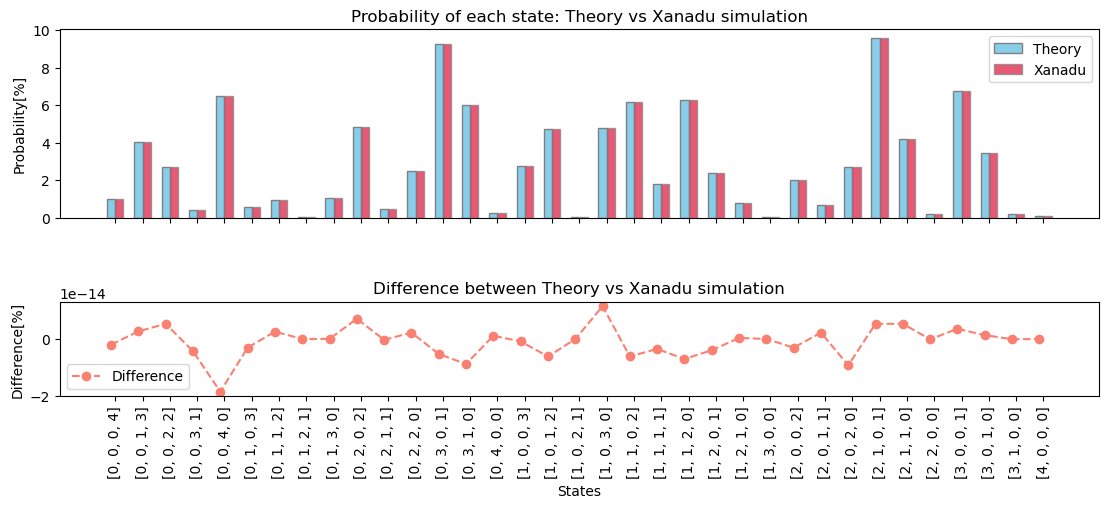

In [32]:
state_probs_theory = [probs_theory(state)*100 for state in measure_states]
state_probs_simulation = [probs[tuple(state)]*100 for state in measure_states]

# Creating labels for the states
state_labels = [str(state) for state in measure_states]

# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(12,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Define r1, r2, and barWidth
barWidth = 0.3
r1 = np.arange(len(state_probs_theory))
r2 = [x + barWidth for x in r1]

# Creating the bar plot in subplot 1
axs[0].bar(r1, state_probs_theory, color='skyblue', width=barWidth, edgecolor='grey', label='Theory')
axs[0].bar(r2, state_probs_simulation, color='#DC143C', alpha=0.7, width=barWidth, edgecolor='grey', label='Xanadu')

# Adding labels and title to subplot 1
axs[0].set_ylabel("Probability[%]")
axs[0].set_title("Probability of each state: Theory vs Xanadu simulation")
axs[0].legend()

# Calculating the difference between theory and simulation
difference = [theory - sim for theory, sim in zip(state_probs_theory, state_probs_simulation)]

# Creating the line plot for difference in subplot 2
axs[1].plot(r1, difference, color='salmon', marker='o', label='Difference', linestyle='dashed')

# Adding labels and title to subplot 2
axs[1].set_xlabel("States")
axs[1].set_ylabel("Difference[%]")
axs[1].set_title("Difference between Theory vs Xanadu simulation")
axs[1].legend()

# Adding x-axis labels for both subplots
plt.xticks([r + barWidth/2 for r in range(len(state_probs_simulation))], state_labels, rotation=90)

# Adjusting layout to prevent overlap
plt.tight_layout(pad=4.0)

#이미지를 경로에 저장. 확장자는 .pdf, .png, .jpeg등 가능
#plt.savefig('/Users/jaewonlee/Lab Code/PQC/Boson Sampling/Fig/BS_Q_4(Xanadu).png', transparent = True)

# Showing the plot
plt.show()

In [33]:
#Fock states generation
#Setting up dimension & number of photons in each mode
#Dimension
Dim = 5

n1 = 1
n2 = 1
n3 = 1 
n4 = 1

#Qubits
qdm1 = fock_dm(Dim, n1) 
qdm2 = fock_dm(Dim, n2) 
qdm3 = fock_dm(Dim, n3) 
qdm4 = fock_dm(Dim, n4) 

#Input density matrix
Inqdm = tensor(qdm1, qdm2, qdm3, qdm4)

#Annihilation operators
a1 = tensor(destroy(Dim), qeye(Dim), qeye(Dim), qeye(Dim))
a2 = tensor(qeye(Dim), destroy(Dim), qeye(Dim), qeye(Dim))
a3 = tensor(qeye(Dim), qeye(Dim), destroy(Dim), qeye(Dim))
a4 = tensor(qeye(Dim), qeye(Dim), qeye(Dim), destroy(Dim))

In [34]:
#Quantum photonics circuit
#Rotation gate function
def rotation_gate(InO, theta):
    OutR = (theta*InO.dag()*InO*1j).expm()
    return OutR
    
#Beamsplitter gate function
def beamsplitter_gate(InO1, InO2, theta, phi):
    OutBS = (theta*(np.exp(phi*1j)*InO1*InO2.dag() - np.exp(-phi*1j)*InO1.dag()*InO2)).expm()
    return OutBS

#Rotation gates
UR1 = rotation_gate(a1, R1)
UR2 = rotation_gate(a2, R2)
UR3 = rotation_gate(a3, R3)
UR4 = rotation_gate(a4, R4)

#Beamsplitter gates
#First part
UBS1 = beamsplitter_gate(a1, a2, BT1, BP1)
UBS2 = beamsplitter_gate(a3, a4, BT2, BP2)
#print(np.round(UBS2, 2))

#Second part
UBS3 = beamsplitter_gate(a2, a3, BT3, BP3)
#print(Frist_UBSO1, Second_UBSO2, Second_UBSO3, Frist_UBSO4)

#Third part
UBS4 = beamsplitter_gate(a1, a2, BT4, BP4)
UBS5 = beamsplitter_gate(a3, a4, BT5, BP5)
#print(Third_UBSO1, Third_UBSO2, Third_UBSO3, Third_UBSO4)

#Fourth part
UBS6 = beamsplitter_gate(a2, a3, BT6, BP6)
#print(Third_UBSO1, Fourth_UBSO2, Fourth_UBSO3, Third_UBSO4)

#Fifth part
UBS7 = beamsplitter_gate(a1, a2, BT7, BP7)
UBS8 = beamsplitter_gate(a3, a4, BT8, BP8)

In [35]:
#Caculating output density matrices
#Rotation gate
OutRqdm = UR4*UR3*UR2*UR1*Inqdm*UR1.dag()*UR2.dag()*UR3.dag()*UR4.dag()
#Beamsplitter gates
#First part
OutBSqdm1 = UBS2*UBS1*OutRqdm*UBS1.dag()*UBS2.dag()
#print(OutBSqdm1.tr())

#Second part
OutBSqdm2 = UBS3*OutBSqdm1*UBS3.dag()
#print(OutBSqdm2.tr())

#Third part
OutBSqdm3 = UBS5*UBS4*OutBSqdm2*UBS4.dag()*UBS5.dag()
#print(OutBSqdm3.tr())

#Fourth part
OutBSqdm4 = UBS6*OutBSqdm3*UBS6.dag()
#print(OutBSqdm4.tr())

#Fifth part
OutBSqdm5 = UBS8*UBS7*OutBSqdm4*UBS7.dag()*UBS8.dag()
#print(OutBSqdm5.tr())

#Output density matrix
Outqdm = OutBSqdm5

In [36]:
#Comparing Theory and Qutip
# Initialize the total probability
total_probability_T = 0  
total_probability_Qutip = 0

#Calculating function
def cal_probability(Output, state):
    m1, m2, m3, m4 = state
    d1 = fock_dm(Dim, m1)
    d2 = fock_dm(Dim, m2)
    d3 = fock_dm(Dim, m3)
    d4 = fock_dm(Dim, m4)
    detection_state = tensor(d1, d2, d3, d4)
    probability = (Output*detection_state).tr()
    return probability

for i, state in enumerate(measure_states):
    prob_Qutip = cal_probability(Outqdm, state)
    print(f"Probability of state(Theory)               {state}: {probs_theory(state)*100}%")
    print(f"Probability of state(Simulation_Qutip)     {state}: {prob_Qutip*100}%")
    total_probability_T += probs_theory(state)
    total_probability_Qutip += prob_Qutip

print(f"Total probability(Theory):           {total_probability_T*100}%")
print(f"Total probability(Simulation_Qutip): {total_probability_Qutip*100}%")

Probability of state(Theory)               [0, 0, 0, 4]: 0.9976245740353498%
Probability of state(Simulation_Qutip)     [0, 0, 0, 4]: 0.9976245740353511%
Probability of state(Theory)               [0, 0, 1, 3]: 4.003119536853783%
Probability of state(Simulation_Qutip)     [0, 0, 1, 3]: 4.003119536853777%
Probability of state(Theory)               [0, 0, 2, 2]: 2.716416141240894%
Probability of state(Simulation_Qutip)     [0, 0, 2, 2]: 2.716416141240887%
Probability of state(Theory)               [0, 0, 3, 1]: 0.414559085628145%
Probability of state(Simulation_Qutip)     [0, 0, 3, 1]: 0.41455908562814897%
Probability of state(Theory)               [0, 0, 4, 0]: 6.469120990886585%
Probability of state(Simulation_Qutip)     [0, 0, 4, 0]: 6.469120990886601%
Probability of state(Theory)               [0, 1, 0, 3]: 0.5511529064587104%
Probability of state(Simulation_Qutip)     [0, 1, 0, 3]: 0.5511529064587144%
Probability of state(Theory)               [0, 1, 1, 2]: 0.9347207459242995%
Proba

In [37]:
for i, state in enumerate(measure_states):
    T = probs_theory(state)
    Q = cal_probability(Outqdm, state)
    E = 100*np.abs(T-Q)/T
    Esum =+ E
    print(f"Error of state {state}: {E}%")
print(f"Average of Error: {Esum/len(measure_states)}%")    

Error of state [0, 0, 0, 4]: 1.3910831959240324e-13%
Error of state [0, 0, 1, 3]: 1.3866973174347508e-13%
Error of state [0, 0, 2, 2]: 2.4267081573519807e-13%
Error of state [0, 0, 3, 1]: 9.624355449118107e-13%
Error of state [0, 0, 4, 0]: 2.359759016735251e-13%
Error of state [0, 1, 0, 3]: 7.239123568053898e-13%
Error of state [0, 1, 1, 2]: 2.041460866140899e-13%
Error of state [0, 1, 2, 1]: 1.3945344197378254e-11%
Error of state [0, 1, 3, 0]: 3.3712060120500205e-14%
Error of state [0, 2, 0, 2]: 1.2891029531443393e-13%
Error of state [0, 2, 1, 1]: 5.5816389105418237e-14%
Error of state [0, 2, 2, 0]: 7.004641159600271e-14%
Error of state [0, 3, 0, 1]: 2.9935469141642864e-14%
Error of state [0, 3, 1, 0]: 1.615225026761435e-13%
Error of state [0, 4, 0, 0]: 4.585641742118518e-13%
Error of state [1, 0, 0, 3]: 1.5179920005796533e-13%
Error of state [1, 0, 1, 2]: 2.789662146582224e-13%
Error of state [1, 0, 2, 1]: 2.405882258517942e-12%
Error of state [1, 0, 3, 0]: 2.173496369531867e-13%
Err

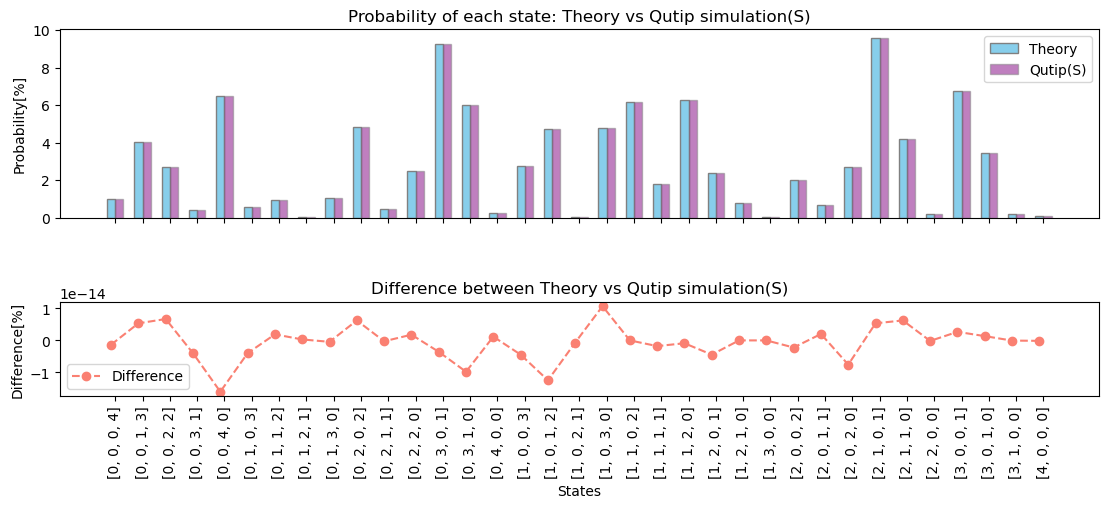

In [38]:
state_probs_theory = [probs_theory(state)*100 for state in measure_states]
state_probs_qutip = [cal_probability(Outqdm, state)*100 for state in measure_states]

# Creating labels for the states
state_labels = [str(state) for state in measure_states]

# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(12,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Define r1, r2, and barWidth
barWidth = 0.3
r1 = np.arange(len(state_probs_theory))
r2 = [x + barWidth for x in r1]

# Creating the bar plot in subplot 1
axs[0].bar(r1, state_probs_theory, color='skyblue', width=barWidth, edgecolor='grey', label='Theory')
axs[0].bar(r2, state_probs_qutip, color='purple', alpha = 0.5, width=barWidth, edgecolor='grey', label='Qutip(S)')

# Adding labels and title to subplot 1
axs[0].set_ylabel("Probability[%]")
axs[0].set_title("Probability of each state: Theory vs Qutip simulation(S)")
axs[0].legend()

# Calculating the difference between theory and simulation
difference = [theory - qutip for theory, qutip in zip(state_probs_theory, state_probs_qutip)]

# Creating the line plot for difference in subplot 2
axs[1].plot(r1, difference, color='salmon', marker='o', label='Difference', linestyle='dashed')

# Adding labels and title to subplot 2
axs[1].set_xlabel("States")
axs[1].set_ylabel("Difference[%]")
axs[1].set_title("Difference between Theory vs Qutip simulation(S)")
axs[1].legend()

# Adding x-axis labels for both subplots
plt.xticks([r + barWidth/2 for r in range(len(state_probs_qutip))], state_labels, rotation=90)

# Adjusting layout to prevent overlap
plt.tight_layout(pad=4.0)

#이미지를 경로에 저장. 확장자는 .pdf, .png, .jpeg등 가능
#plt.savefig('/Users/jaewonlee/Lab Code/PQC/Boson Sampling/Fig/BS_Q_4(Qutip_S).png', transparent = True)

# Showing the plot
plt.show()